In [ ]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
!pip install -q tfds-nightly
import tensorflow_datasets as tfds
ds, info = tfds.load('inobus_pet_v5', with_info=True, data_dir='gs://pet_dataset/inobus_pet_v5')

     |████████████████████████████████| 3.9MB 4.0MB/s 


In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tensorflow.keras import layers

In [ ]:
train_ds, test_ds = ds['train'], ds['test']

In [ ]:
# tfds.as_dataframe(train_ds.take(10), info)
# tfds.as_dataframe(test_ds.take(10), info)
# fig  = tfds.show_examples(train_ds, info)
# fig  = tfds.show_examples(test_ds, info)

In [ ]:
print(f'Number of classes: {info.features["label"].num_classes}')
print(f'dtypes: {info.features.dtype}')
print(f'Image Shape: {info.features["image"].shape}')

Number of classes: 2
dtypes: {'image': tf.uint8, 'label': tf.int64}
Image Shape: (2464, 3280, 3)


In [ ]:
def insert_history(name, df, his):
  keys = ['val_accuracy', 'val_precision', 'val_recall']
  num_epochs = len(his.history['accuracy']) 
  for i in range(num_epochs - 1, -1, -1):
    df.loc[-1] = [name, i + 1, his.history['val_accuracy'][i],
                       his.history['val_precision'][i], his.history['val_recall'][i]]
    df.index += 1

# Prepare dataset

In [ ]:
@tf.function
def load_image_label(datapoint):
  img = datapoint['image']
  label = datapoint['label']

  return img, label

In [ ]:
train_ds = train_ds.map(load_image_label)
test_ds = test_ds.map(load_image_label)

In [ ]:
def prepare_train_ds(ds):
  batch_size = 32
  buffer_size = 1000

  ds = ds.cache().shuffle(buffer_size).batch(batch_size)
  ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)

  return ds

In [ ]:
def prepare_test_ds(ds):
  batch_size = 32
  buffer_size = 1000

  ds = ds.cache().batch(batch_size)
  ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)

  return ds

In [ ]:
def get_ds_with_shape(img_shape):
  """
    img_shape: tuple. e.g. (224, 224, 3)
  """
  resizer = layers.experimental.preprocessing.Resizing(img_shape[0], img_shape[1])
  train = train_ds.map(lambda x, y: (resizer(x), y))
  test= test_ds.map(lambda x, y: (resizer(x), y))

  train = prepare_train_ds(train)
  test = prepare_test_ds(test)

  return train, test


In [ ]:
train_ds_616, test_ds_616 = get_ds_with_shape((616, 616, 3))
train_ds_448, test_ds_448 = get_ds_with_shape((448, 448, 3))
train_ds_224, test_ds_224 = get_ds_with_shape((224, 224, 3))
train_ds_192, test_ds_192 = get_ds_with_shape((192, 192, 3))
train_ds_160, test_ds_160 = get_ds_with_shape((160, 160, 3))
train_ds_128, test_ds_128 = get_ds_with_shape((128, 128, 3))
train_ds_96, test_ds_96 = get_ds_with_shape((96, 96, 3))

# Prepare MobileNet

In [ ]:
augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomRotation(0.1, fill_mode='constant'),
    layers.experimental.preprocessing.RandomRotation(0.1, fill_mode='constant'),
])

In [ ]:
def get_mobilenet_with_shape(img_shape, alpha=1.0, dropout=0.001, lr=3e-5):
  inputs = tf.keras.Input(shape=(img_shape))
  x = tf.cast(inputs, tf.float32)
  
  x = tf.keras.applications.mobilenet.preprocess_input(x)

  mobilenet_base = tf.keras.applications.MobileNet(
      input_shape=img_shape,
      alpha=alpha,
      dropout=dropout,
      include_top=False,
      weights='imagenet'
  )

  x = mobilenet_base(x)
  x = tf.keras.layers.GlobalAveragePooling2D()(x)
  outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

  model = tf.keras.Model(inputs, outputs)

  model.compile(optimizer=tf.keras.optimizers.Adam(lr=lr),
                loss= tf.keras.losses.BinaryCrossentropy(from_logits=False),
                metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')])

  return model


## MobileNet V1 224

In [ ]:
img_shape = (224, 224, 3)
mobilenet_224 = get_mobilenet_with_shape(img_shape, alpha=1.0, dropout=0.001)

17227776/17225924 [==============================] - 0s 0us/step


In [ ]:
epochs = 40
his_224 = mobilenet_224.fit(train_ds_224, epochs=epochs, validation_data=test_ds_224)

Epoch 1/40
24/24 [==============================] - 62s 635ms/step - loss: 0.5856 - accuracy: 0.6569 - precision: 0.8901 - recall: 0.6692 - val_loss: 1.0106 - val_accuracy: 0.3000 - val_precision: 1.0000 - val_recall: 0.0200
Epoch 2/40
24/24 [==============================] - 3s 145ms/step - loss: 0.1681 - accuracy: 0.9981 - precision: 1.0000 - recall: 0.9979 - val_loss: 1.0636 - val_accuracy: 0.2929 - val_precision: 1.0000 - val_recall: 0.0100
Epoch 3/40
24/24 [==============================] - 4s 149ms/step - loss: 0.0676 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 1.1240 - val_accuracy: 0.3071 - val_precision: 1.0000 - val_recall: 0.0300
Epoch 4/40
24/24 [==============================] - 3s 145ms/step - loss: 0.0446 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 1.1127 - val_accuracy: 0.3357 - val_precision: 1.0000 - val_recall: 0.0700
Epoch 5/40
24/24 [==============================] - 4s 149ms/step - loss: 0.0308 - accuracy: 1.0000 - p

In [ ]:
img_shape = (224, 224, 3)
mobilenet_224_2 = get_mobilenet_with_shape(img_shape, alpha=1.0, dropout=0.1)
epochs = 40
his_224_2 = mobilenet_224_2.fit(train_ds_224, epochs=epochs, validation_data=test_ds_224)

Epoch 1/40
24/24 [==============================] - 6s 168ms/step - loss: 0.6714 - accuracy: 0.6225 - precision: 0.9374 - recall: 0.6082 - val_loss: 2.7761 - val_accuracy: 0.2857 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/40
24/24 [==============================] - 3s 144ms/step - loss: 0.1771 - accuracy: 0.9874 - precision: 0.9999 - recall: 0.9857 - val_loss: 3.2564 - val_accuracy: 0.2857 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/40
24/24 [==============================] - 3s 142ms/step - loss: 0.0833 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 2.9501 - val_accuracy: 0.2857 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/40
24/24 [==============================] - 3s 143ms/step - loss: 0.0482 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 2.7439 - val_accuracy: 0.2857 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/40
24/24 [==============================] - 3s 144ms/step - loss

In [ ]:
img_shape = (224, 224, 3)
mobilenet_224_3 = get_mobilenet_with_shape(img_shape, alpha=1.0, dropout=0.3)
epochs = 40
his_224_3 = mobilenet_224_3.fit(train_ds_224, epochs=epochs, validation_data=test_ds_224)

Epoch 1/40
24/24 [==============================] - 6s 171ms/step - loss: 0.5499 - accuracy: 0.7212 - precision: 0.9081 - recall: 0.7425 - val_loss: 0.9158 - val_accuracy: 0.3286 - val_precision: 1.0000 - val_recall: 0.0600
Epoch 2/40
24/24 [==============================] - 4s 149ms/step - loss: 0.1359 - accuracy: 0.9983 - precision: 1.0000 - recall: 0.9980 - val_loss: 1.0593 - val_accuracy: 0.2929 - val_precision: 1.0000 - val_recall: 0.0100
Epoch 3/40
24/24 [==============================] - 4s 148ms/step - loss: 0.0756 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.8992 - val_accuracy: 0.3429 - val_precision: 1.0000 - val_recall: 0.0800
Epoch 4/40
24/24 [==============================] - 4s 147ms/step - loss: 0.0404 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.6894 - val_accuracy: 0.6000 - val_precision: 1.0000 - val_recall: 0.4400
Epoch 5/40
24/24 [==============================] - 4s 148ms/step - loss: 0.0319 - accuracy: 1.0000 - pr

In [ ]:
img_shape = (224, 224, 3)
mobilenet_224_4 = get_mobilenet_with_shape(img_shape, alpha=0.75, dropout=0.001)
epochs = 40
his_224_4 = mobilenet_224_4.fit(train_ds_224, epochs=epochs, validation_data=test_ds_224)

10633216/10626956 [==============================] - 0s 0us/step
Epoch 1/40
24/24 [==============================] - 6s 150ms/step - loss: 0.5301 - accuracy: 0.7517 - precision: 0.8916 - recall: 0.8108 - val_loss: 0.6591 - val_accuracy: 0.5929 - val_precision: 0.8525 - val_recall: 0.5200
Epoch 2/40
24/24 [==============================] - 3s 125ms/step - loss: 0.1898 - accuracy: 0.9740 - precision: 0.9932 - recall: 0.9761 - val_loss: 0.5759 - val_accuracy: 0.6786 - val_precision: 0.9661 - val_recall: 0.5700
Epoch 3/40
24/24 [==============================] - 3s 122ms/step - loss: 0.0952 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.6263 - val_accuracy: 0.6643 - val_precision: 1.0000 - val_recall: 0.5300
Epoch 4/40
24/24 [==============================] - 3s 123ms/step - loss: 0.0747 - accuracy: 0.9999 - precision: 1.0000 - recall: 0.9999 - val_loss: 0.5551 - val_accuracy: 0.7286 - val_precision: 1.0000 - val_recall: 0.6200
Epoch 5/40
24/24 [=====================

In [ ]:
img_shape = (224, 224, 3)
mobilenet_224_5 = get_mobilenet_with_shape(img_shape, alpha=0.75, dropout=0.1)
epochs = 40
his_224_5 = mobilenet_224_5.fit(train_ds_224, epochs=epochs, validation_data=test_ds_224)

Epoch 1/40
24/24 [==============================] - 6s 146ms/step - loss: 0.5787 - accuracy: 0.7378 - precision: 0.8798 - recall: 0.8010 - val_loss: 0.8079 - val_accuracy: 0.4214 - val_precision: 0.7714 - val_recall: 0.2700
Epoch 2/40
24/24 [==============================] - 3s 123ms/step - loss: 0.1998 - accuracy: 0.9863 - precision: 0.9966 - recall: 0.9875 - val_loss: 0.7962 - val_accuracy: 0.4929 - val_precision: 0.8372 - val_recall: 0.3600
Epoch 3/40
24/24 [==============================] - 3s 129ms/step - loss: 0.1091 - accuracy: 0.9978 - precision: 1.0000 - recall: 0.9975 - val_loss: 0.6975 - val_accuracy: 0.5643 - val_precision: 0.8679 - val_recall: 0.4600
Epoch 4/40
24/24 [==============================] - 3s 122ms/step - loss: 0.0631 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.6053 - val_accuracy: 0.6071 - val_precision: 0.8462 - val_recall: 0.5500
Epoch 5/40
24/24 [==============================] - 3s 126ms/step - loss: 0.0523 - accuracy: 1.0000 - pr

In [ ]:
img_shape = (224, 224, 3)
mobilenet_224_6 = get_mobilenet_with_shape(img_shape, alpha=0.75, dropout=0.3)
epochs = 40
his_224_6 = mobilenet_224_6.fit(train_ds_224, epochs=epochs, validation_data=test_ds_224)

Epoch 1/40
24/24 [==============================] - 6s 146ms/step - loss: 0.8667 - accuracy: 0.4253 - precision: 0.8735 - recall: 0.3698 - val_loss: 1.1758 - val_accuracy: 0.2857 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/40
24/24 [==============================] - 3s 122ms/step - loss: 0.3645 - accuracy: 0.8997 - precision: 1.0000 - recall: 0.8889 - val_loss: 1.0790 - val_accuracy: 0.3000 - val_precision: 1.0000 - val_recall: 0.0200
Epoch 3/40
24/24 [==============================] - 3s 123ms/step - loss: 0.1677 - accuracy: 0.9973 - precision: 1.0000 - recall: 0.9969 - val_loss: 0.9122 - val_accuracy: 0.4000 - val_precision: 1.0000 - val_recall: 0.1600
Epoch 4/40
24/24 [==============================] - 3s 120ms/step - loss: 0.0994 - accuracy: 0.9952 - precision: 1.0000 - recall: 0.9945 - val_loss: 0.8333 - val_accuracy: 0.4500 - val_precision: 1.0000 - val_recall: 0.2300
Epoch 5/40
24/24 [==============================] - 3s 119ms/step - loss: 0.0596 - accuracy: 1.0

In [ ]:
img_shape = (224, 224, 3)
mobilenet_224_7 = get_mobilenet_with_shape(img_shape, alpha=0.5, dropout=0.001)
epochs = 40
his_224_7 = mobilenet_224_7.fit(train_ds_224, epochs=epochs, validation_data=test_ds_224)

5578752/5577668 [==============================] - 0s 0us/step
Epoch 1/40
24/24 [==============================] - 5s 131ms/step - loss: 0.3569 - accuracy: 0.8850 - precision: 0.8861 - recall: 0.9972 - val_loss: 0.5781 - val_accuracy: 0.7143 - val_precision: 0.7344 - val_recall: 0.9400
Epoch 2/40
24/24 [==============================] - 2s 102ms/step - loss: 0.1765 - accuracy: 0.9580 - precision: 0.9536 - recall: 0.9995 - val_loss: 0.5197 - val_accuracy: 0.7500 - val_precision: 0.8351 - val_recall: 0.8100
Epoch 3/40
24/24 [==============================] - 2s 103ms/step - loss: 0.1028 - accuracy: 0.9924 - precision: 0.9922 - recall: 0.9992 - val_loss: 0.5009 - val_accuracy: 0.7857 - val_precision: 0.8804 - val_recall: 0.8100
Epoch 4/40
24/24 [==============================] - 2s 102ms/step - loss: 0.0710 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.4749 - val_accuracy: 0.8071 - val_precision: 0.8925 - val_recall: 0.8300
Epoch 5/40
24/24 [=======================

In [ ]:
img_shape = (224, 224, 3)
mobilenet_224_8 = get_mobilenet_with_shape(img_shape, alpha=0.5, dropout=0.1)
epochs = 40
his_224_8 = mobilenet_224_8.fit(train_ds_224, epochs=epochs, validation_data=test_ds_224)

Epoch 1/40
24/24 [==============================] - 5s 126ms/step - loss: 0.7309 - accuracy: 0.5326 - precision: 0.9002 - recall: 0.5241 - val_loss: 0.5266 - val_accuracy: 0.7786 - val_precision: 0.8791 - val_recall: 0.8000
Epoch 2/40
24/24 [==============================] - 2s 102ms/step - loss: 0.3833 - accuracy: 0.9008 - precision: 0.9831 - recall: 0.9027 - val_loss: 0.5414 - val_accuracy: 0.7143 - val_precision: 0.8750 - val_recall: 0.7000
Epoch 3/40
24/24 [==============================] - 2s 101ms/step - loss: 0.2295 - accuracy: 0.9797 - precision: 1.0000 - recall: 0.9765 - val_loss: 0.5080 - val_accuracy: 0.7357 - val_precision: 0.8795 - val_recall: 0.7300
Epoch 4/40
24/24 [==============================] - 2s 100ms/step - loss: 0.1439 - accuracy: 0.9990 - precision: 1.0000 - recall: 0.9988 - val_loss: 0.4818 - val_accuracy: 0.7357 - val_precision: 0.8795 - val_recall: 0.7300
Epoch 5/40
24/24 [==============================] - 2s 102ms/step - loss: 0.1109 - accuracy: 1.0000 - pr

In [ ]:
img_shape = (224, 224, 3)
mobilenet_224_9 = get_mobilenet_with_shape(img_shape, alpha=0.5, dropout=0.3)
epochs = 40
his_224_9 = mobilenet_224_9.fit(train_ds_224, epochs=epochs, validation_data=test_ds_224)

Epoch 1/40
24/24 [==============================] - 5s 126ms/step - loss: 0.4650 - accuracy: 0.8220 - precision: 0.9092 - recall: 0.8855 - val_loss: 0.5867 - val_accuracy: 0.7143 - val_precision: 0.8750 - val_recall: 0.7000
Epoch 2/40
24/24 [==============================] - 2s 102ms/step - loss: 0.2111 - accuracy: 0.9865 - precision: 0.9847 - recall: 1.0000 - val_loss: 0.5299 - val_accuracy: 0.7786 - val_precision: 0.9726 - val_recall: 0.7100
Epoch 3/40
24/24 [==============================] - 2s 101ms/step - loss: 0.1348 - accuracy: 0.9952 - precision: 0.9945 - recall: 1.0000 - val_loss: 0.4433 - val_accuracy: 0.8143 - val_precision: 0.9205 - val_recall: 0.8100
Epoch 4/40
24/24 [==============================] - 2s 102ms/step - loss: 0.0988 - accuracy: 0.9981 - precision: 0.9978 - recall: 1.0000 - val_loss: 0.3857 - val_accuracy: 0.8500 - val_precision: 0.9072 - val_recall: 0.8800
Epoch 5/40
24/24 [==============================] - 2s 101ms/step - loss: 0.0625 - accuracy: 0.9999 - pr

In [ ]:
history_224 = pd.DataFrame({
    'name': pd.Series([], dtype='str'),
    'epoch': pd.Series([], dtype='int'),
    'accuracy': pd.Series([], dtype='float'),
    'precision': pd.Series([], dtype='float'),
    'recall': pd.Series([], dtype='float')
})

In [ ]:
insert_history('v1_s=224_a=1.0_d=0.001', history_224, his_224)
insert_history('v1_s=224_a=1.0_d=0.1', history_224, his_224_2)
insert_history('v1_s=224_a=1.0_d=0.3', history_224, his_224_3)
insert_history('v1_s=224_a=0.75_d=0.001', history_224, his_224_4)
insert_history('v1_s=224_a=0.75_d=0.1', history_224, his_224_5)
insert_history('v1_s=224_a=0.75_d=0.3', history_224, his_224_6)
insert_history('v1_s=224_a=0.5_d=0.001', history_224, his_224_7)
insert_history('v1_s=224_a=0.5_d=0.1', history_224, his_224_8)
insert_history('v1_s=224_a=0.5_d=0.3', history_224, his_224_9)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


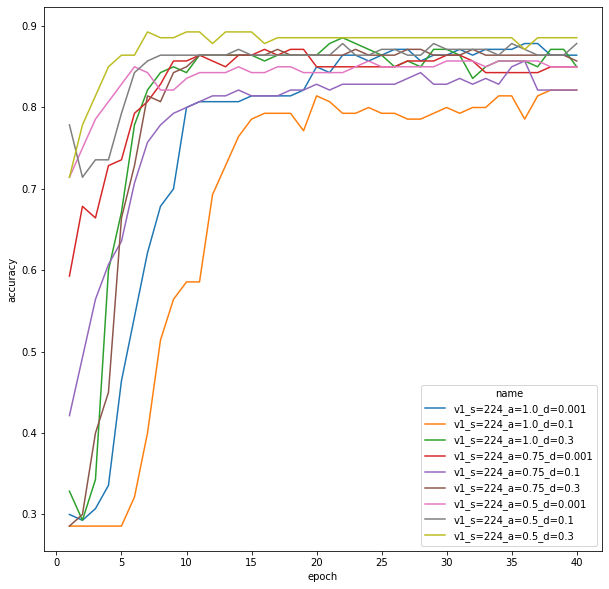

In [ ]:
f, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.lineplot('epoch', 'accuracy', data=history_224, hue='name')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


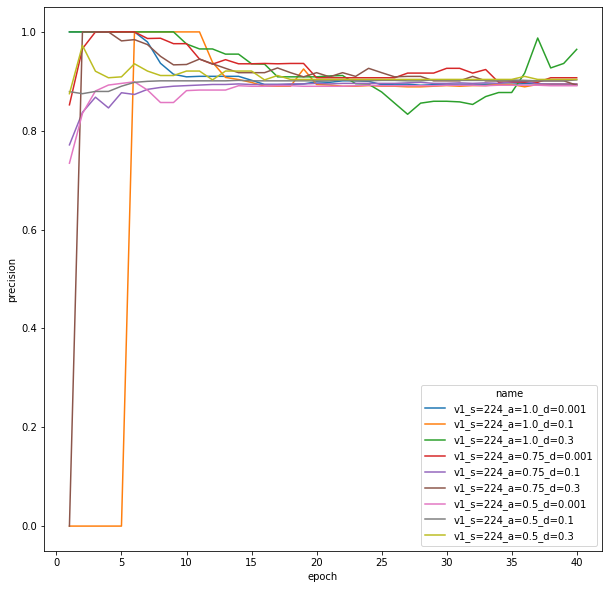

In [ ]:
f, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.lineplot('epoch', 'precision', data=history_224, hue='name')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


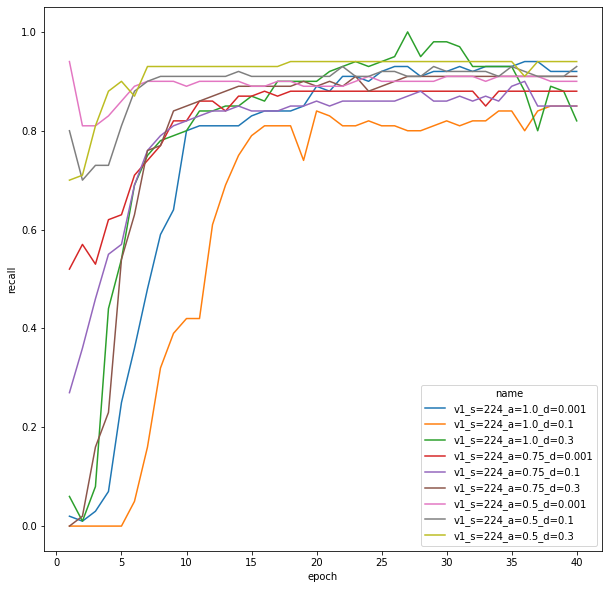

In [ ]:
f, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.lineplot('epoch', 'recall', data=history_224, hue='name')

## MobileNet V1 616

In [ ]:
# img_shape = (616, 616, 3)
# mobilenet_616 = get_mobilenet_with_shape(img_shape)

# mobilenet_616.compile(optimizer=tf.keras.optimizers.Adam(lr=3e-4),
#                       loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
#                       metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')])

# epochs = 20
# his_616 = mobilenet_616.fit(train_ds_616, epochs=epochs, validation_data=test_ds_616)

## MobileNet V1 448 

In [ ]:
img_shape = (448, 448, 3)
mobilenet_448 = get_mobilenet_with_shape(img_shape, alpha=1.0, dropout=0.001)
epochs = 40
his_448 = mobilenet_448.fit(train_ds_448, epochs=epochs, validation_data=test_ds_448)

Epoch 1/40
24/24 [==============================] - 59s 1s/step - loss: 0.9447 - accuracy: 0.3313 - precision: 0.9416 - recall: 0.2442 - val_loss: 1.7127 - val_accuracy: 0.2857 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/40
24/24 [==============================] - 14s 567ms/step - loss: 0.2833 - accuracy: 0.9585 - precision: 0.9992 - recall: 0.9537 - val_loss: 2.4162 - val_accuracy: 0.2857 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/40
24/24 [==============================] - 13s 562ms/step - loss: 0.1091 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 2.7207 - val_accuracy: 0.2857 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/40
24/24 [==============================] - 14s 565ms/step - loss: 0.0676 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 2.2857 - val_accuracy: 0.2857 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/40
24/24 [==============================] - 13s 551ms/step - lo

In [ ]:
img_shape = (448, 448, 3)
mobilenet_448_2 = get_mobilenet_with_shape(img_shape, alpha=1.0, dropout=0.1)
epochs = 40
his_448_2 = mobilenet_448_2.fit(train_ds_448, epochs=epochs, validation_data=test_ds_448)

Epoch 1/40
24/24 [==============================] - 17s 593ms/step - loss: 0.4200 - accuracy: 0.8671 - precision: 0.9201 - recall: 0.9301 - val_loss: 1.3835 - val_accuracy: 0.2857 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/40
24/24 [==============================] - 14s 563ms/step - loss: 0.1386 - accuracy: 0.9938 - precision: 0.9948 - recall: 0.9980 - val_loss: 1.7253 - val_accuracy: 0.2857 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/40
24/24 [==============================] - 14s 569ms/step - loss: 0.0652 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 1.8108 - val_accuracy: 0.2857 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/40
24/24 [==============================] - 14s 569ms/step - loss: 0.0389 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 1.6723 - val_accuracy: 0.2857 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/40
24/24 [==============================] - 14s 573ms/step -

In [ ]:
img_shape = (448, 448, 3)
mobilenet_448_3 = get_mobilenet_with_shape(img_shape, alpha=1.0, dropout=0.3)
epochs = 40
his_448_3 = mobilenet_448_3.fit(train_ds_448, epochs=epochs, validation_data=test_ds_448)

Epoch 1/40
24/24 [==============================] - 16s 587ms/step - loss: 0.5825 - accuracy: 0.7414 - precision: 0.9204 - recall: 0.7481 - val_loss: 1.6297 - val_accuracy: 0.2857 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/40
24/24 [==============================] - 14s 570ms/step - loss: 0.1711 - accuracy: 0.9988 - precision: 0.9986 - recall: 1.0000 - val_loss: 2.3679 - val_accuracy: 0.2857 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/40
24/24 [==============================] - 14s 569ms/step - loss: 0.0790 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 2.3309 - val_accuracy: 0.2857 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/40
24/24 [==============================] - 14s 568ms/step - loss: 0.0439 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 2.3153 - val_accuracy: 0.2857 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/40
24/24 [==============================] - 14s 562ms/step -

In [ ]:
img_shape = (448, 448, 3)
mobilenet_448_4 = get_mobilenet_with_shape(img_shape, alpha=0.75, dropout=0.001)
epochs = 40
his_448_4 = mobilenet_448_4.fit(train_ds_448, epochs=epochs, validation_data=test_ds_448)

Epoch 1/40
24/24 [==============================] - 15s 524ms/step - loss: 1.2709 - accuracy: 0.1608 - precision: 0.8400 - recall: 0.0461 - val_loss: 2.7366 - val_accuracy: 0.2857 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/40
24/24 [==============================] - 11s 475ms/step - loss: 0.4996 - accuracy: 0.7883 - precision: 0.9942 - recall: 0.7577 - val_loss: 3.2491 - val_accuracy: 0.2857 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/40
24/24 [==============================] - 11s 462ms/step - loss: 0.2337 - accuracy: 0.9794 - precision: 0.9964 - recall: 0.9802 - val_loss: 3.6013 - val_accuracy: 0.2857 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/40
24/24 [==============================] - 11s 461ms/step - loss: 0.1180 - accuracy: 0.9996 - precision: 0.9995 - recall: 1.0000 - val_loss: 3.0956 - val_accuracy: 0.2857 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/40
24/24 [==============================] - 11s 462ms/step -

In [ ]:
img_shape = (448, 448, 3)
mobilenet_448_5 = get_mobilenet_with_shape(img_shape, alpha=0.75, dropout=0.1)
epochs = 40
his_448_5 = mobilenet_448_5.fit(train_ds_448, epochs=epochs, validation_data=test_ds_448)

Epoch 1/40
24/24 [==============================] - 14s 501ms/step - loss: 0.3268 - accuracy: 0.9035 - precision: 0.8999 - recall: 1.0000 - val_loss: 0.5532 - val_accuracy: 0.7429 - val_precision: 0.7353 - val_recall: 1.0000
Epoch 2/40
24/24 [==============================] - 12s 483ms/step - loss: 0.1580 - accuracy: 0.9721 - precision: 0.9686 - recall: 1.0000 - val_loss: 0.5005 - val_accuracy: 0.8286 - val_precision: 0.8878 - val_recall: 0.8700
Epoch 3/40
24/24 [==============================] - 12s 486ms/step - loss: 0.0788 - accuracy: 0.9995 - precision: 0.9995 - recall: 1.0000 - val_loss: 0.4653 - val_accuracy: 0.8143 - val_precision: 0.9111 - val_recall: 0.8200
Epoch 4/40
24/24 [==============================] - 11s 477ms/step - loss: 0.0503 - accuracy: 0.9990 - precision: 0.9989 - recall: 1.0000 - val_loss: 0.4251 - val_accuracy: 0.8357 - val_precision: 0.9326 - val_recall: 0.8300
Epoch 5/40
24/24 [==============================] - 12s 485ms/step - loss: 0.0346 - accuracy: 1.0000

In [ ]:
img_shape = (448, 448, 3)
mobilenet_448_6 = get_mobilenet_with_shape(img_shape, alpha=0.75, dropout=0.3)
epochs = 40
his_448_6 = mobilenet_448_6.fit(train_ds_448, epochs=epochs, validation_data=test_ds_448)

Epoch 1/40
24/24 [==============================] - 15s 496ms/step - loss: 0.9727 - accuracy: 0.2641 - precision: 0.9982 - recall: 0.1573 - val_loss: 1.7315 - val_accuracy: 0.2857 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/40
24/24 [==============================] - 11s 478ms/step - loss: 0.4038 - accuracy: 0.9104 - precision: 0.9851 - recall: 0.9104 - val_loss: 2.9156 - val_accuracy: 0.2857 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/40
24/24 [==============================] - 11s 480ms/step - loss: 0.1994 - accuracy: 0.9913 - precision: 0.9982 - recall: 0.9920 - val_loss: 3.2453 - val_accuracy: 0.2857 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/40
24/24 [==============================] - 11s 472ms/step - loss: 0.1126 - accuracy: 0.9935 - precision: 0.9925 - recall: 1.0000 - val_loss: 3.4155 - val_accuracy: 0.2857 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/40
24/24 [==============================] - 12s 485ms/step -

In [ ]:
img_shape = (448, 448, 3)
mobilenet_448_7 = get_mobilenet_with_shape(img_shape, alpha=0.5, dropout=0.001)
epochs = 40
his_448_7 = mobilenet_448_7.fit(train_ds_448, epochs=epochs, validation_data=test_ds_448)

Epoch 1/40
24/24 [==============================] - 12s 407ms/step - loss: 1.0446 - accuracy: 0.1800 - precision: 0.7516 - recall: 0.0493 - val_loss: 0.9329 - val_accuracy: 0.2857 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/40
24/24 [==============================] - 9s 378ms/step - loss: 0.5559 - accuracy: 0.7459 - precision: 0.9922 - recall: 0.7284 - val_loss: 0.9968 - val_accuracy: 0.2857 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/40
24/24 [==============================] - 9s 382ms/step - loss: 0.2983 - accuracy: 0.9778 - precision: 0.9893 - recall: 0.9856 - val_loss: 1.0466 - val_accuracy: 0.2857 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/40
24/24 [==============================] - 9s 378ms/step - loss: 0.1854 - accuracy: 0.9924 - precision: 0.9927 - recall: 0.9986 - val_loss: 0.9805 - val_accuracy: 0.3214 - val_precision: 1.0000 - val_recall: 0.0500
Epoch 5/40
24/24 [==============================] - 9s 374ms/step - loss: 0.128

In [ ]:
img_shape = (448, 448, 3)
mobilenet_448_8 = get_mobilenet_with_shape(img_shape, alpha=0.5, dropout=0.1)
epochs = 40
his_448_8 = mobilenet_448_8.fit(train_ds_448, epochs=epochs, validation_data=test_ds_448)

Epoch 1/40
24/24 [==============================] - 12s 408ms/step - loss: 0.3315 - accuracy: 0.8844 - precision: 0.8841 - recall: 1.0000 - val_loss: 0.5191 - val_accuracy: 0.8214 - val_precision: 0.8000 - val_recall: 1.0000
Epoch 2/40
24/24 [==============================] - 9s 384ms/step - loss: 0.2174 - accuracy: 0.9249 - precision: 0.9205 - recall: 1.0000 - val_loss: 0.5560 - val_accuracy: 0.8214 - val_precision: 0.9870 - val_recall: 0.7600
Epoch 3/40
24/24 [==============================] - 9s 385ms/step - loss: 0.1222 - accuracy: 0.9777 - precision: 0.9748 - recall: 1.0000 - val_loss: 0.5698 - val_accuracy: 0.7429 - val_precision: 0.9848 - val_recall: 0.6500
Epoch 4/40
24/24 [==============================] - 9s 388ms/step - loss: 0.0806 - accuracy: 0.9978 - precision: 0.9974 - recall: 1.0000 - val_loss: 0.6185 - val_accuracy: 0.6357 - val_precision: 1.0000 - val_recall: 0.4900
Epoch 5/40
24/24 [==============================] - 9s 387ms/step - loss: 0.0625 - accuracy: 1.0000 - p

In [ ]:
img_shape = (448, 448, 3)
mobilenet_448_9 = get_mobilenet_with_shape(img_shape, alpha=0.5, dropout=0.3)
epochs = 40
his_448_9 = mobilenet_448_9.fit(train_ds_448, epochs=epochs, validation_data=test_ds_448)

Epoch 1/40
24/24 [==============================] - 12s 412ms/step - loss: 0.5591 - accuracy: 0.7310 - precision: 0.8744 - recall: 0.8078 - val_loss: 0.5856 - val_accuracy: 0.7857 - val_precision: 0.8241 - val_recall: 0.8900
Epoch 2/40
24/24 [==============================] - 9s 388ms/step - loss: 0.2804 - accuracy: 0.9757 - precision: 0.9726 - recall: 1.0000 - val_loss: 0.6555 - val_accuracy: 0.6071 - val_precision: 0.9592 - val_recall: 0.4700
Epoch 3/40
24/24 [==============================] - 9s 389ms/step - loss: 0.1722 - accuracy: 0.9951 - precision: 0.9945 - recall: 1.0000 - val_loss: 0.6967 - val_accuracy: 0.5714 - val_precision: 0.9762 - val_recall: 0.4100
Epoch 4/40
24/24 [==============================] - 9s 386ms/step - loss: 0.1139 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.6746 - val_accuracy: 0.5929 - val_precision: 0.9216 - val_recall: 0.4700
Epoch 5/40
24/24 [==============================] - 9s 386ms/step - loss: 0.0880 - accuracy: 0.9975 - p

In [ ]:
history_448 = pd.DataFrame({
    'name': pd.Series([], dtype='str'),
    'epoch': pd.Series([], dtype='int'),
    'accuracy': pd.Series([], dtype='float'),
    'precision': pd.Series([], dtype='float'),
    'recall': pd.Series([], dtype='float')
})

insert_history('v1_s=448_a=1.0_d=0.001', history_448, his_448)
insert_history('v1_s=448_a=1.0_d=0.1', history_448, his_448_2)
insert_history('v1_s=448_a=1.0_d=0.3', history_448, his_448_3)
insert_history('v1_s=448_a=0.75_d=0.001', history_448, his_448_4)
insert_history('v1_s=448_a=0.75_d=0.1', history_448, his_448_5)
insert_history('v1_s=448_a=0.75_d=0.3', history_448, his_448_6)
insert_history('v1_s=448_a=0.5_d=0.001', history_448, his_448_7)
insert_history('v1_s=448_a=0.5_d=0.1', history_448, his_448_8)
insert_history('v1_s=448_a=0.5_d=0.3', history_448, his_448_9)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


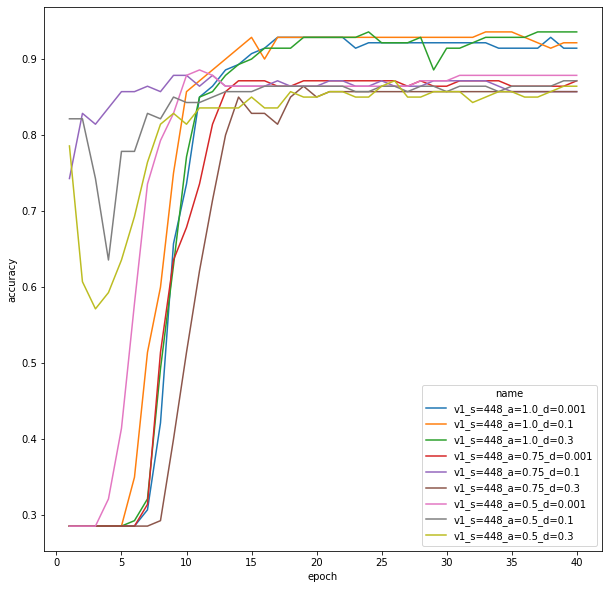

In [ ]:
f, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.lineplot('epoch', 'accuracy', data=history_448, hue='name')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


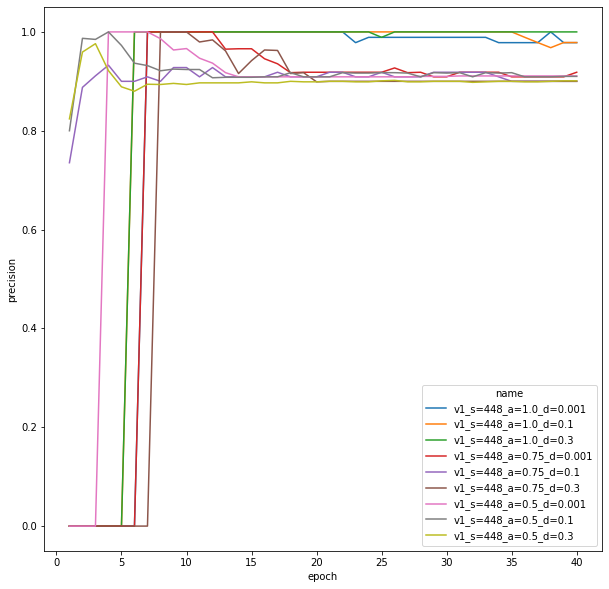

In [ ]:
f, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.lineplot('epoch', 'precision', data=history_448, hue='name')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


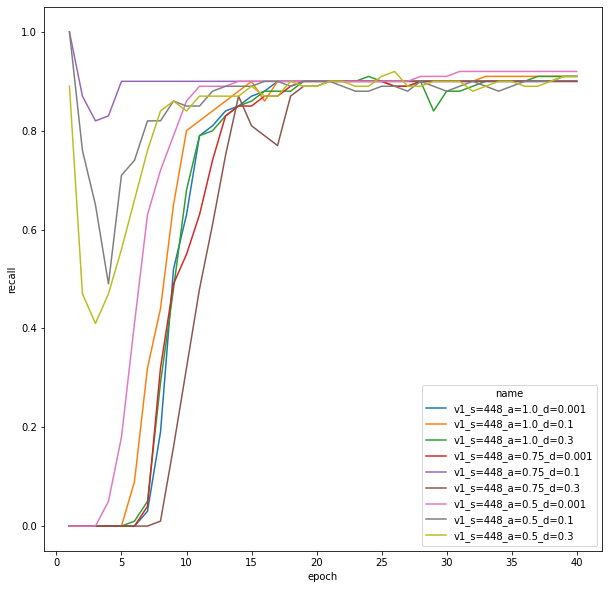

In [ ]:
f, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.lineplot('epoch', 'recall', data=history_448, hue='name')

## MobileNet V1 192

In [ ]:
img_shape = (192, 192, 3)
mobilenet_192 = get_mobilenet_with_shape(img_shape, alpha=1.0, dropout=0.001)
epochs = 40
his_192 = mobilenet_192.fit(train_ds_192, epochs=epochs, validation_data=test_ds_192)

17227776/17225924 [==============================] - 0s 0us/step
Epoch 1/40
24/24 [==============================] - 45s 574ms/step - loss: 0.4906 - accuracy: 0.7868 - precision: 0.9572 - recall: 0.7886 - val_loss: 1.3146 - val_accuracy: 0.3071 - val_precision: 1.0000 - val_recall: 0.0300
Epoch 2/40
24/24 [==============================] - 3s 113ms/step - loss: 0.1436 - accuracy: 0.9910 - precision: 1.0000 - recall: 0.9899 - val_loss: 0.9660 - val_accuracy: 0.4143 - val_precision: 1.0000 - val_recall: 0.1800
Epoch 3/40
24/24 [==============================] - 3s 113ms/step - loss: 0.0589 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.7552 - val_accuracy: 0.5071 - val_precision: 1.0000 - val_recall: 0.3100
Epoch 4/40
24/24 [==============================] - 3s 112ms/step - loss: 0.0453 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.5632 - val_accuracy: 0.6786 - val_precision: 1.0000 - val_recall: 0.5500
Epoch 5/40
24/24 [====================

In [ ]:
img_shape = (192, 192, 3)
mobilenet_192_2 = get_mobilenet_with_shape(img_shape, alpha=1.0, dropout=0.1)
epochs = 40
his_192_2 = mobilenet_192_2.fit(train_ds_192, epochs=epochs, validation_data=test_ds_192)

Epoch 1/40
24/24 [==============================] - 5s 137ms/step - loss: 1.3068 - accuracy: 0.2050 - precision: 1.0000 - recall: 0.1072 - val_loss: 1.5552 - val_accuracy: 0.3000 - val_precision: 1.0000 - val_recall: 0.0200
Epoch 2/40
24/24 [==============================] - 3s 113ms/step - loss: 0.4471 - accuracy: 0.7953 - precision: 1.0000 - recall: 0.7670 - val_loss: 2.0382 - val_accuracy: 0.2857 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/40
24/24 [==============================] - 3s 111ms/step - loss: 0.1895 - accuracy: 0.9782 - precision: 1.0000 - recall: 0.9760 - val_loss: 2.2308 - val_accuracy: 0.2857 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/40
24/24 [==============================] - 3s 112ms/step - loss: 0.0710 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 1.6295 - val_accuracy: 0.3714 - val_precision: 1.0000 - val_recall: 0.1200
Epoch 5/40
24/24 [==============================] - 3s 110ms/step - loss: 0.0600 - accur

In [ ]:
img_shape = (192, 192, 3)
mobilenet_192_3 = get_mobilenet_with_shape(img_shape, alpha=1.0, dropout=0.3)
epochs = 40
his_192_3 = mobilenet_192_3.fit(train_ds_192, epochs=epochs, validation_data=test_ds_192)

Epoch 1/40
24/24 [==============================] - 5s 136ms/step - loss: 0.8910 - accuracy: 0.4208 - precision: 0.9540 - recall: 0.3302 - val_loss: 1.9120 - val_accuracy: 0.2857 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/40
24/24 [==============================] - 3s 110ms/step - loss: 0.2871 - accuracy: 0.9449 - precision: 1.0000 - recall: 0.9374 - val_loss: 1.8553 - val_accuracy: 0.2857 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/40
24/24 [==============================] - 3s 111ms/step - loss: 0.1287 - accuracy: 0.9971 - precision: 1.0000 - recall: 0.9967 - val_loss: 1.9294 - val_accuracy: 0.2857 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/40
24/24 [==============================] - 3s 113ms/step - loss: 0.0755 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 1.6330 - val_accuracy: 0.3214 - val_precision: 1.0000 - val_recall: 0.0500
Epoch 5/40
24/24 [==============================] - 3s 111ms/step - loss: 0.0488

In [ ]:
img_shape = (192, 192, 3)
mobilenet_192_4 = get_mobilenet_with_shape(img_shape, alpha=0.75, dropout=0.001)
epochs = 40
his_192_4 = mobilenet_192_4.fit(train_ds_192, epochs=epochs, validation_data=test_ds_192)

Epoch 1/40
24/24 [==============================] - 5s 127ms/step - loss: 0.5142 - accuracy: 0.7632 - precision: 0.9569 - recall: 0.7597 - val_loss: 0.7222 - val_accuracy: 0.5357 - val_precision: 0.9268 - val_recall: 0.3800
Epoch 2/40
24/24 [==============================] - 2s 93ms/step - loss: 0.1810 - accuracy: 0.9952 - precision: 1.0000 - recall: 0.9946 - val_loss: 0.5437 - val_accuracy: 0.7500 - val_precision: 0.9114 - val_recall: 0.7200
Epoch 3/40
24/24 [==============================] - 2s 95ms/step - loss: 0.0952 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.4930 - val_accuracy: 0.7786 - val_precision: 0.9157 - val_recall: 0.7600
Epoch 4/40
24/24 [==============================] - 2s 96ms/step - loss: 0.0717 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.3992 - val_accuracy: 0.8071 - val_precision: 0.9011 - val_recall: 0.8200
Epoch 5/40
24/24 [==============================] - 2s 97ms/step - loss: 0.0445 - accuracy: 1.0000 - precis

In [ ]:
img_shape = (192, 192, 3)
mobilenet_192_5 = get_mobilenet_with_shape(img_shape, alpha=0.75, dropout=0.1)
epochs = 40
his_192_5 = mobilenet_192_5.fit(train_ds_192, epochs=epochs, validation_data=test_ds_192)

Epoch 1/40
24/24 [==============================] - 5s 118ms/step - loss: 0.3135 - accuracy: 0.8997 - precision: 0.9005 - recall: 0.9951 - val_loss: 0.4546 - val_accuracy: 0.8000 - val_precision: 0.7812 - val_recall: 1.0000
Epoch 2/40
24/24 [==============================] - 2s 95ms/step - loss: 0.0959 - accuracy: 0.9952 - precision: 0.9944 - recall: 1.0000 - val_loss: 0.3896 - val_accuracy: 0.8929 - val_precision: 0.8696 - val_recall: 1.0000
Epoch 3/40
24/24 [==============================] - 2s 92ms/step - loss: 0.0532 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.3576 - val_accuracy: 0.9214 - val_precision: 0.9009 - val_recall: 1.0000
Epoch 4/40
24/24 [==============================] - 2s 95ms/step - loss: 0.0354 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.3302 - val_accuracy: 0.8786 - val_precision: 0.8952 - val_recall: 0.9400
Epoch 5/40
24/24 [==============================] - 2s 94ms/step - loss: 0.0253 - accuracy: 1.0000 - precis

In [ ]:
img_shape = (192, 192, 3)
mobilenet_192_6 = get_mobilenet_with_shape(img_shape, alpha=0.75, dropout=0.3)
epochs = 40
his_192_6 = mobilenet_192_6.fit(train_ds_192, epochs=epochs, validation_data=test_ds_192)

Epoch 1/40
24/24 [==============================] - 5s 117ms/step - loss: 0.5181 - accuracy: 0.7757 - precision: 0.8772 - recall: 0.8604 - val_loss: 0.5302 - val_accuracy: 0.7500 - val_precision: 0.7407 - val_recall: 1.0000
Epoch 2/40
24/24 [==============================] - 2s 94ms/step - loss: 0.1732 - accuracy: 0.9927 - precision: 0.9971 - recall: 0.9945 - val_loss: 0.4131 - val_accuracy: 0.8500 - val_precision: 0.8264 - val_recall: 1.0000
Epoch 3/40
24/24 [==============================] - 2s 93ms/step - loss: 0.0972 - accuracy: 0.9981 - precision: 0.9978 - recall: 1.0000 - val_loss: 0.3634 - val_accuracy: 0.8643 - val_precision: 0.8584 - val_recall: 0.9700
Epoch 4/40
24/24 [==============================] - 2s 93ms/step - loss: 0.0609 - accuracy: 0.9952 - precision: 1.0000 - recall: 0.9946 - val_loss: 0.3283 - val_accuracy: 0.8714 - val_precision: 0.8796 - val_recall: 0.9500
Epoch 5/40
24/24 [==============================] - 2s 95ms/step - loss: 0.0410 - accuracy: 1.0000 - precis

In [ ]:
img_shape = (192, 192, 3)
mobilenet_192_7 = get_mobilenet_with_shape(img_shape, alpha=0.5, dropout=0.001)
epochs = 40
his_192_7 = mobilenet_192_7.fit(train_ds_192, epochs=epochs, validation_data=test_ds_192)

5578752/5577668 [==============================] - 0s 0us/step
Epoch 1/40
24/24 [==============================] - 6s 110ms/step - loss: 0.7597 - accuracy: 0.5215 - precision: 0.9139 - recall: 0.4703 - val_loss: 0.4942 - val_accuracy: 0.8571 - val_precision: 0.9651 - val_recall: 0.8300
Epoch 2/40
24/24 [==============================] - 2s 79ms/step - loss: 0.3702 - accuracy: 0.9123 - precision: 0.9941 - recall: 0.9058 - val_loss: 0.4104 - val_accuracy: 0.8643 - val_precision: 0.9263 - val_recall: 0.8800
Epoch 3/40
24/24 [==============================] - 2s 79ms/step - loss: 0.2058 - accuracy: 0.9741 - precision: 0.9996 - recall: 0.9712 - val_loss: 0.3518 - val_accuracy: 0.8714 - val_precision: 0.9020 - val_recall: 0.9200
Epoch 4/40
24/24 [==============================] - 2s 79ms/step - loss: 0.1432 - accuracy: 0.9921 - precision: 0.9964 - recall: 0.9946 - val_loss: 0.3232 - val_accuracy: 0.8714 - val_precision: 0.9100 - val_recall: 0.9100
Epoch 5/40
24/24 [==========================

In [ ]:
img_shape = (192, 192, 3)
mobilenet_192_8 = get_mobilenet_with_shape(img_shape, alpha=0.5, dropout=0.1)
epochs = 40
his_192_8 = mobilenet_192_8.fit(train_ds_192, epochs=epochs, validation_data=test_ds_192)

Epoch 1/40
24/24 [==============================] - 5s 103ms/step - loss: 1.0201 - accuracy: 0.3159 - precision: 0.9374 - recall: 0.2345 - val_loss: 0.8178 - val_accuracy: 0.4786 - val_precision: 0.7872 - val_recall: 0.3700
Epoch 2/40
24/24 [==============================] - 2s 78ms/step - loss: 0.5376 - accuracy: 0.7220 - precision: 0.9953 - recall: 0.6907 - val_loss: 0.6594 - val_accuracy: 0.6500 - val_precision: 0.8592 - val_recall: 0.6100
Epoch 3/40
24/24 [==============================] - 2s 78ms/step - loss: 0.2897 - accuracy: 0.9327 - precision: 0.9997 - recall: 0.9243 - val_loss: 0.5527 - val_accuracy: 0.7500 - val_precision: 0.8824 - val_recall: 0.7500
Epoch 4/40
24/24 [==============================] - 2s 77ms/step - loss: 0.1721 - accuracy: 0.9820 - precision: 1.0000 - recall: 0.9794 - val_loss: 0.5050 - val_accuracy: 0.7786 - val_precision: 0.8876 - val_recall: 0.7900
Epoch 5/40
24/24 [==============================] - 2s 78ms/step - loss: 0.1259 - accuracy: 0.9925 - precis

In [ ]:
img_shape = (192, 192, 3)
mobilenet_192_9 = get_mobilenet_with_shape(img_shape, alpha=0.5, dropout=0.3)
epochs = 40
his_192_9 = mobilenet_192_9.fit(train_ds_192, epochs=epochs, validation_data=test_ds_192)

Epoch 1/40
24/24 [==============================] - 5s 103ms/step - loss: 0.6297 - accuracy: 0.6257 - precision: 0.8629 - recall: 0.6774 - val_loss: 0.5717 - val_accuracy: 0.7286 - val_precision: 0.7246 - val_recall: 1.0000
Epoch 2/40
24/24 [==============================] - 2s 76ms/step - loss: 0.2952 - accuracy: 0.9327 - precision: 0.9754 - recall: 0.9474 - val_loss: 0.5081 - val_accuracy: 0.7786 - val_precision: 0.7634 - val_recall: 1.0000
Epoch 3/40
24/24 [==============================] - 2s 77ms/step - loss: 0.1681 - accuracy: 0.9929 - precision: 0.9969 - recall: 0.9951 - val_loss: 0.4569 - val_accuracy: 0.8357 - val_precision: 0.8130 - val_recall: 1.0000
Epoch 4/40
24/24 [==============================] - 2s 78ms/step - loss: 0.1086 - accuracy: 0.9968 - precision: 0.9980 - recall: 0.9983 - val_loss: 0.4193 - val_accuracy: 0.8571 - val_precision: 0.8333 - val_recall: 1.0000
Epoch 5/40
24/24 [==============================] - 2s 77ms/step - loss: 0.0808 - accuracy: 0.9974 - precis

In [ ]:
history_192 = pd.DataFrame({
    'name': pd.Series([], dtype='str'),
    'epoch': pd.Series([], dtype='int'),
    'accuracy': pd.Series([], dtype='float'),
    'precision': pd.Series([], dtype='float'),
    'recall': pd.Series([], dtype='float')
})

insert_history('v1_s=192_a=1.0_d=0.001', history_192, his_192)
insert_history('v1_s=192_a=1.0_d=0.1', history_192, his_192_2)
insert_history('v1_s=192_a=1.0_d=0.3', history_192, his_192_3)
insert_history('v1_s=192_a=0.75_d=0.001', history_192, his_192_4)
insert_history('v1_s=192_a=0.75_d=0.1', history_192, his_192_5)
insert_history('v1_s=192_a=0.75_d=0.3', history_192, his_192_6)
insert_history('v1_s=192_a=0.5_d=0.001', history_192, his_192_7)
insert_history('v1_s=192_a=0.5_d=0.1', history_192, his_192_8)
insert_history('v1_s=192_a=0.5_d=0.3', history_192, his_192_9)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


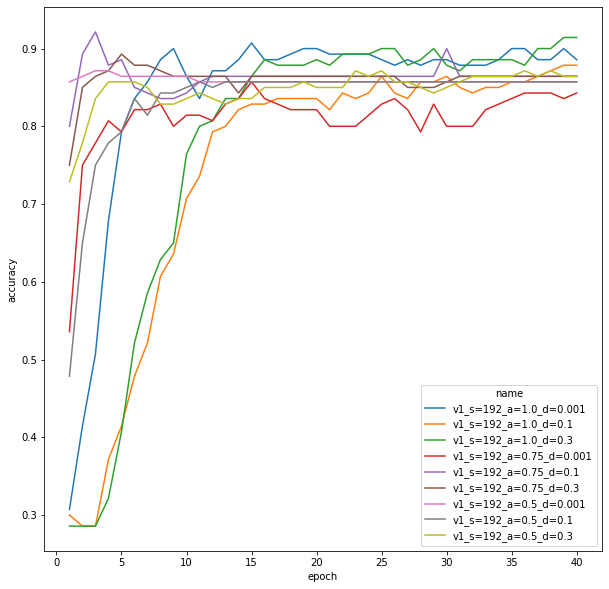

In [ ]:
f, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.lineplot('epoch', 'accuracy', data=history_192, hue='name')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


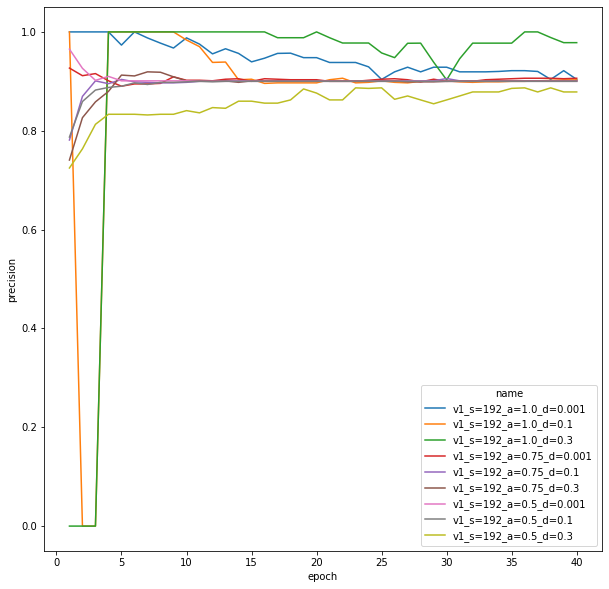

In [ ]:
f, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.lineplot('epoch', 'precision', data=history_192, hue='name')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


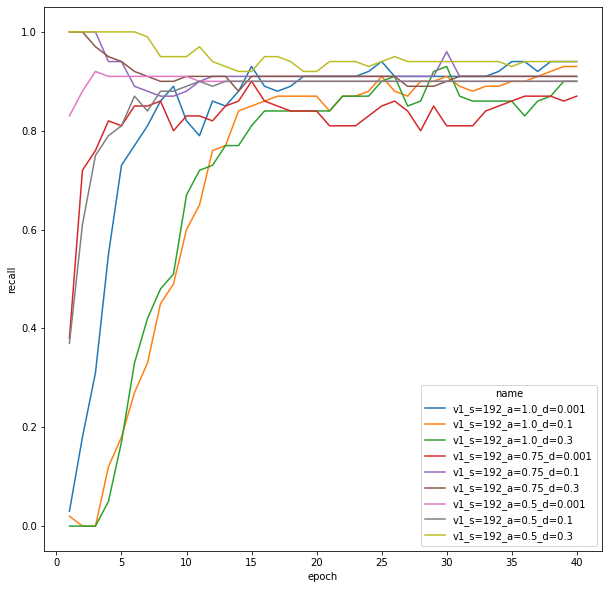

In [ ]:
f, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.lineplot('epoch', 'recall', data=history_192, hue='name')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


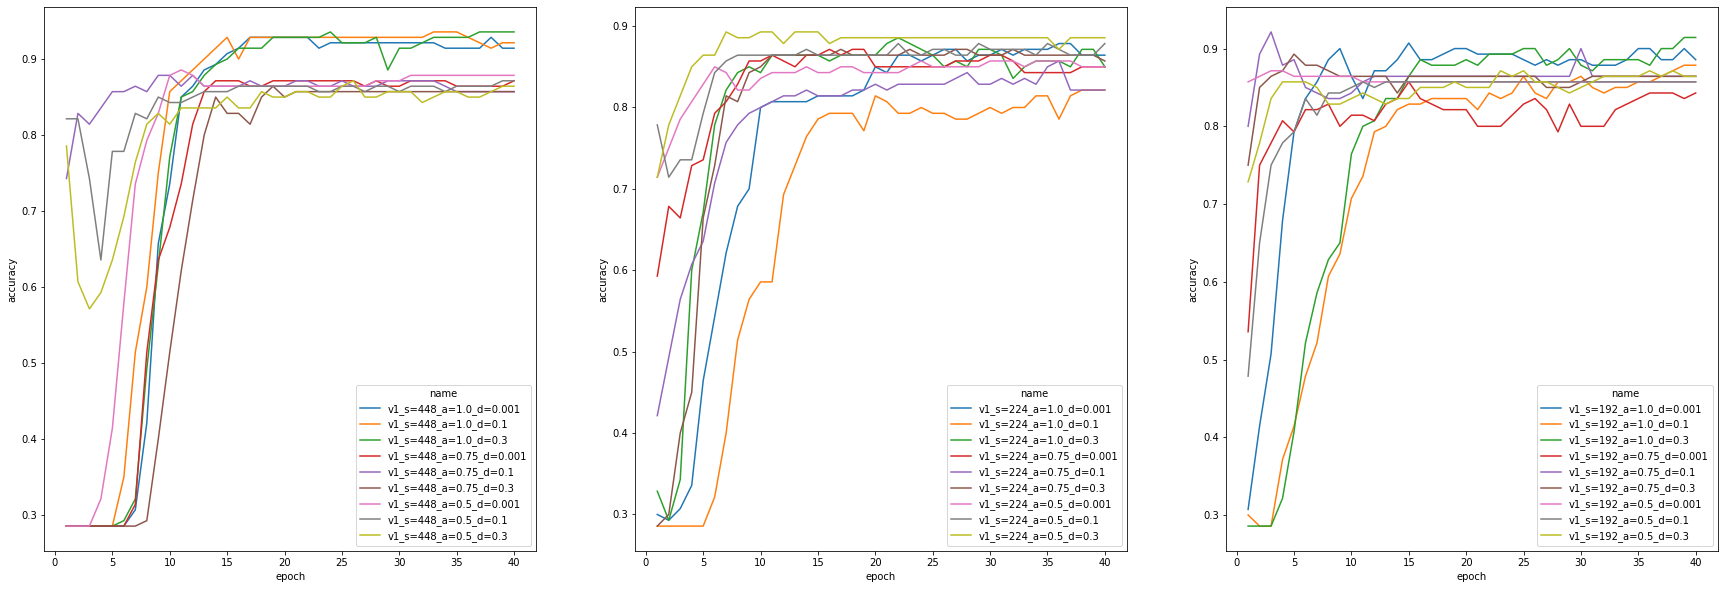

In [ ]:
f, ax = plt.subplots(1, 3, figsize=(30, 10))

sns.lineplot('epoch', 'accuracy', data=history_448, hue='name', ax=ax[0])
sns.lineplot('epoch', 'accuracy', data=history_224, hue='name', ax=ax[1])
sns.lineplot('epoch', 'accuracy', data=history_192, hue='name', ax=ax[2])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


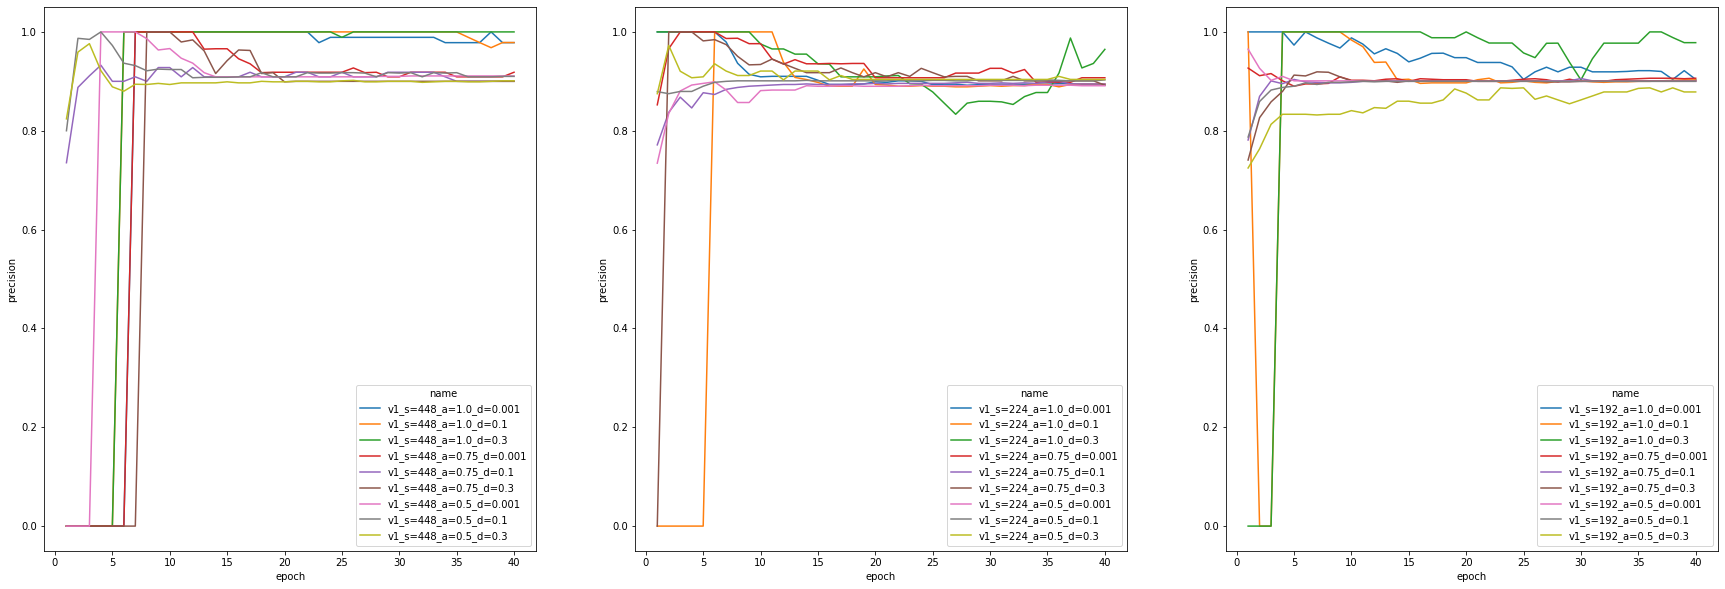

In [ ]:
f, ax = plt.subplots(1, 3, figsize=(30, 10))

sns.lineplot('epoch', 'precision', data=history_448, hue='name', ax=ax[0])
sns.lineplot('epoch', 'precision', data=history_224, hue='name', ax=ax[1])
sns.lineplot('epoch', 'precision', data=history_192, hue='name', ax=ax[2])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


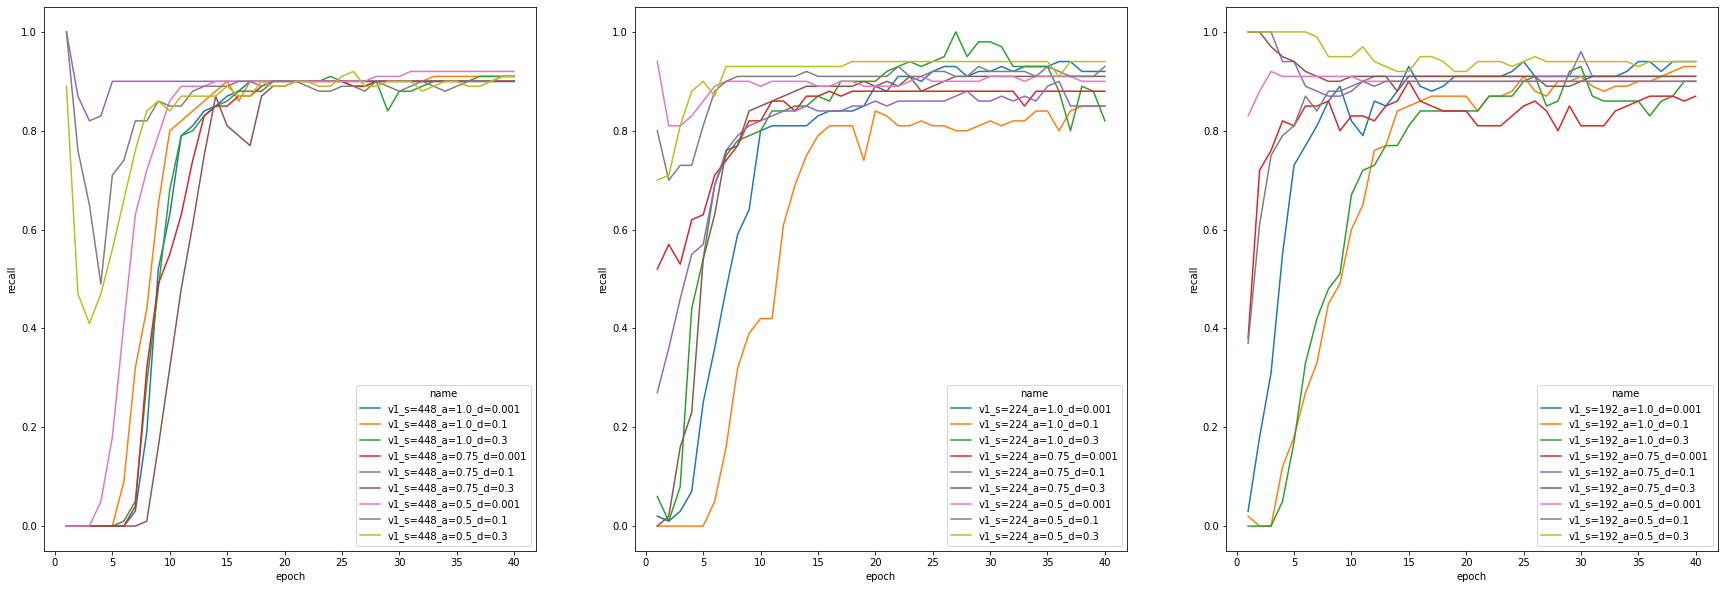

In [ ]:
f, ax = plt.subplots(1, 3, figsize=(30, 10))

sns.lineplot('epoch', 'recall', data=history_448, hue='name', ax=ax[0])
sns.lineplot('epoch', 'recall', data=history_224, hue='name', ax=ax[1])
sns.lineplot('epoch', 'recall', data=history_192, hue='name', ax=ax[2])

In [ ]:
history_merged = pd.concat([history_448, history_224, history_192])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


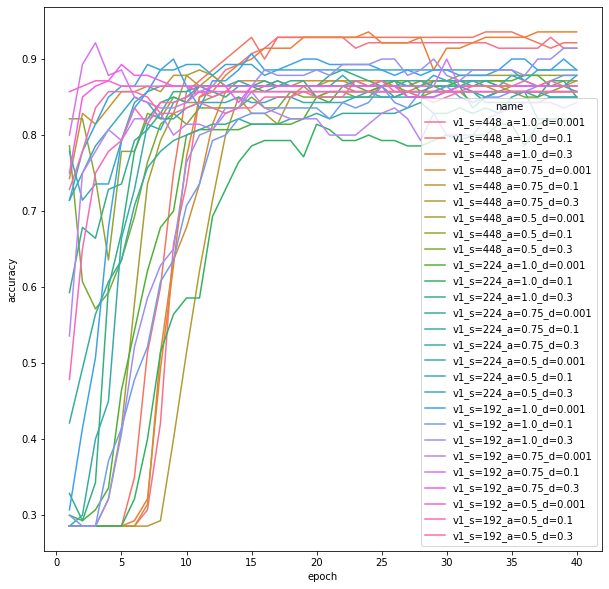

In [ ]:
f, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.lineplot('epoch', 'accuracy', data=history_merged, hue='name')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


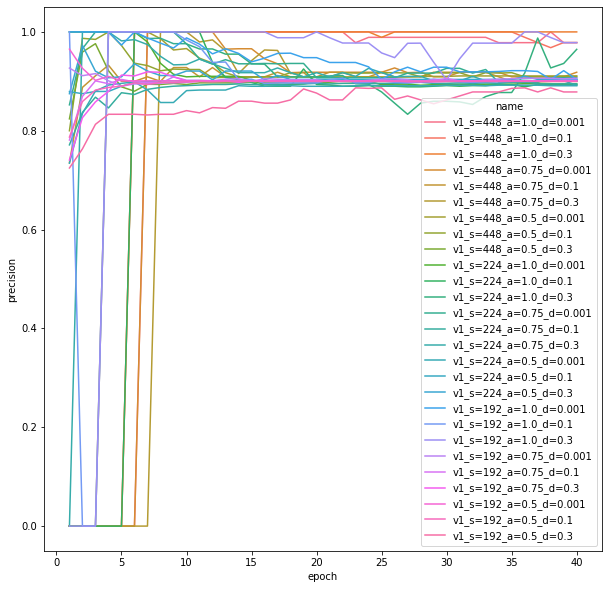

In [ ]:
f, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.lineplot('epoch', 'precision', data=history_merged, hue='name')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


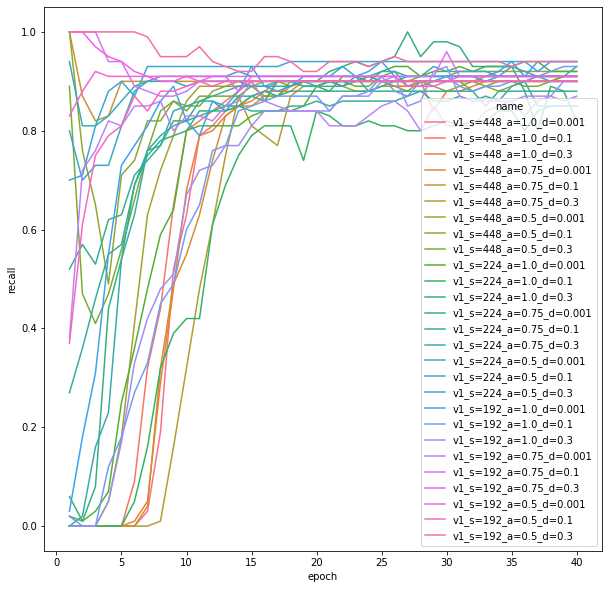

In [ ]:
f, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.lineplot('epoch', 'recall', data=history_merged, hue='name')

In [ ]:
history_merged = history_merged.sort_index()
history_merged.to_csv('history_merged.csv', header=True, index=False)

In [ ]:
history_merged[history_merged['epoch'] == 40].sort_values(by=['accuracy'], ascending=False)

,name,epoch,accuracy,precision,recall
279,v1_s=448_a=1.0_d=0.3,40,0.935714,1.000000,0.91
319,v1_s=448_a=1.0_d=0.1,40,0.921429,0.978495,0.91
359,v1_s=448_a=1.0_d=0.001,40,0.914286,0.978261,0.90
279,v1_s=192_a=1.0_d=0.3,40,0.914286,0.978261,0.90
39,v1_s=224_a=0.5_d=0.3,40,0.885714,0.903846,0.94
359,v1_s=192_a=1.0_d=0.001,40,0.885714,0.903846,0.94
79,v1_s=224_a=0.5_d=0.1,40,0.878571,0.902913,0.93
319,v1_s=192_a=1.0_d=0.1,40,0.878571,0.902913,0.93
119,v1_s=448_a=0.5_d=0.001,40,0.878571,0.910891,0.92
79,v1_s=448_a=0.5_d=0.1,40,0.871429,0.910000,0.91


In [ ]:
history_merged[history_merged['epoch'] == 40].sort_values(by=['precision'], ascending=False)

,name,epoch,accuracy,precision,recall
279,v1_s=448_a=1.0_d=0.3,40,0.935714,1.000000,0.91
319,v1_s=448_a=1.0_d=0.1,40,0.921429,0.978495,0.91
359,v1_s=448_a=1.0_d=0.001,40,0.914286,0.978261,0.90
279,v1_s=192_a=1.0_d=0.3,40,0.914286,0.978261,0.90
279,v1_s=224_a=1.0_d=0.3,40,0.850000,0.964706,0.82
239,v1_s=448_a=0.75_d=0.001,40,0.871429,0.918367,0.90
119,v1_s=448_a=0.5_d=0.001,40,0.878571,0.910891,0.92
79,v1_s=448_a=0.5_d=0.1,40,0.871429,0.910000,0.91
239,v1_s=224_a=0.75_d=0.001,40,0.850000,0.907216,0.88
239,v1_s=192_a=0.75_d=0.001,40,0.842857,0.906250,0.87


In [ ]:
history_merged[history_merged['epoch'] == 40].sort_values(by=['recall'], ascending=False)

,name,epoch,accuracy,precision,recall
39,v1_s=192_a=0.5_d=0.3,40,0.864286,0.878505,0.94
39,v1_s=224_a=0.5_d=0.3,40,0.885714,0.903846,0.94
359,v1_s=192_a=1.0_d=0.001,40,0.885714,0.903846,0.94
79,v1_s=224_a=0.5_d=0.1,40,0.878571,0.902913,0.93
319,v1_s=192_a=1.0_d=0.1,40,0.878571,0.902913,0.93
359,v1_s=224_a=1.0_d=0.001,40,0.864286,0.893204,0.92
119,v1_s=448_a=0.5_d=0.001,40,0.878571,0.910891,0.92
39,v1_s=448_a=0.5_d=0.3,40,0.864286,0.900990,0.91
319,v1_s=448_a=1.0_d=0.1,40,0.921429,0.978495,0.91
279,v1_s=448_a=1.0_d=0.3,40,0.935714,1.000000,0.91
